# Billboard Year-End Hot 100: Artist Collaboration Network

Source data can be found here: https://www.kaggle.com/rakannimer/billboard-lyrics

Zoom and hover over nodes to see details.

* Node size: number of occurrence of the artist
* Node color: number of collaborating artists

See below to see how this network was generated.

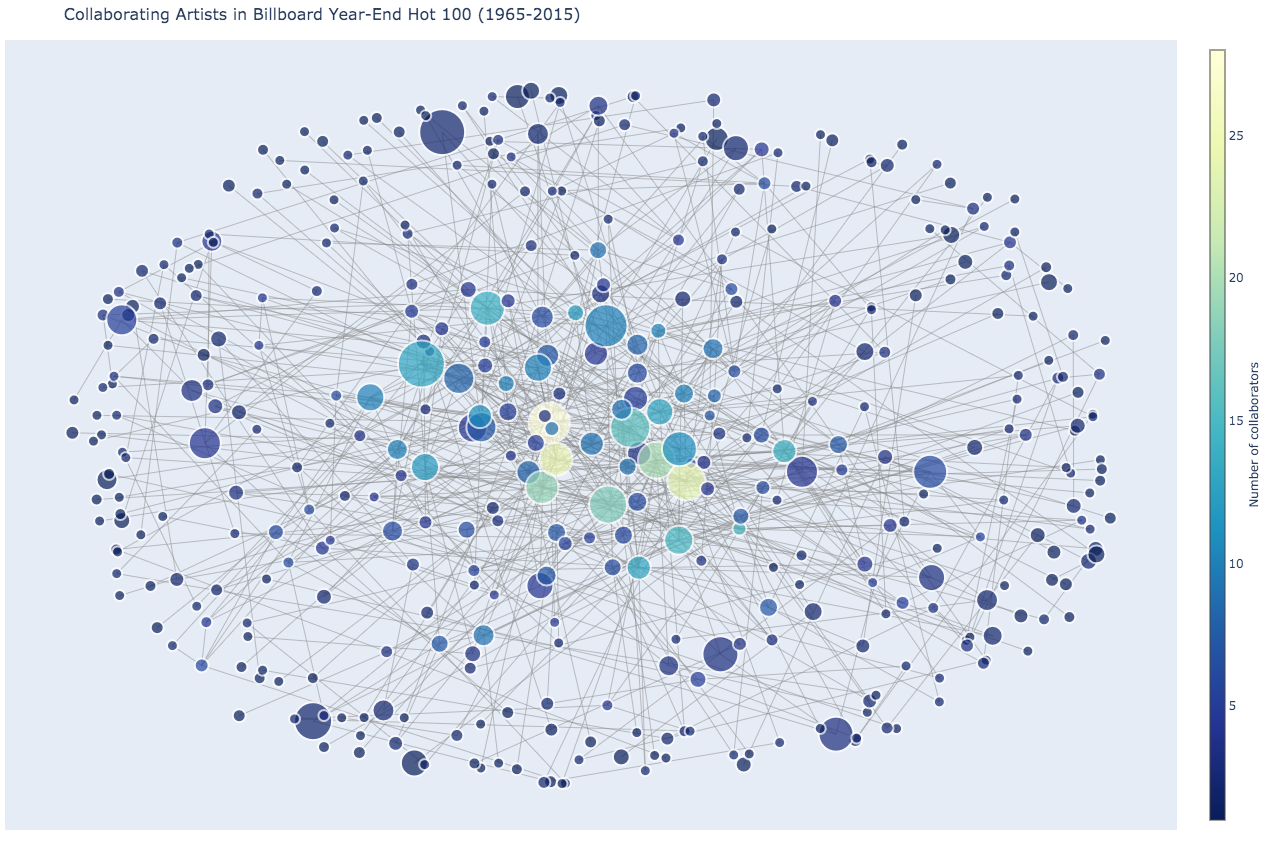

In [28]:
fig.update_layout(height=850)
fig.show()

## 0. Imports

In [12]:
from itertools import chain, combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

import networkx as nx
import plotly.graph_objects as go

## 1. Preprocess data

In [2]:
df = pd.read_csv('../data/billboard_yearly_100_1964-2015.csv')
df.drop(['Source', 'Song'], axis=1, inplace=True)
df.columns

Index(['Rank', 'Artist', 'Year'], dtype='object')

Break up `Artist` into individual artists.

In [3]:
def get_artists(x):
    l = x.split(' featuring ')
    ll = []
    for y in l:
        ll.extend(y.split(' and '))
    lll = []
    for y in ll:
        lll.extend(y.split(' with '))
    return ll

df.loc[:, 'collaborators'] = df.Artist.apply(get_artists)

In [4]:
# Inspect string manually
# uniques = np.unique(list(chain(*df.collaborators.tolist())))

Split strings that need further splitting.

In [6]:
to_split = [
    # (<artist string>, <split indices>)
    ('carly simon  james taylor', [11]),
    ("christina aguilera lil kim m'ya", [18, 22]),
    ('da brat left eye missy elliott', [7, 16]),
    ('daryl hall  john oates', [10]),
    ('dionne warwick  the spinners', [14]),
    ('gary lewis  the playboys',[10]), 
    ('kenny loggins  stevie nicks', [13]),
    ('kenny rogers  kim carnes', [12]),
    ('kenny rogers  the first edition', [12]),
    ('olivia newtonjohn  cliff richard', [17]),
    ('nicki minaj bebe rexha', [11]),
    ('roberta flack  donny hathaway', [13]),
    ('nelly p diddy', [5]),
    ('nelly paul wall', [5]),
    ('rihanna kanye west', [7]),
    ('paul anka  odia coates', [9]),
    ('paul mccartney  wings', [14]),
    ('neil diamond  barbra streisand', [12]),
    ('neil sedaka  elton john', [11]),
    ('murray head  the trindad singers', [11]),
    ( 'heavy d  the boyz', [7]),
    ('french montana too short or tyga', [14, 18]),  # split at 'or'
    ('jessie j ariana grande', [8]),
    ('friends dionne warwick gladys knight elton john', [7, 22, 36]),
    ('miley cyrus wiz khalifa', [11]),
    ('heavy d  the boyz', [7]),
    ('kanye west big sean pusha t', [10, 19]),
    ( 'kanye west lil wayne',[10]),
    ('jermaine dupri da brat', [14]),
    ('jerry butler  brenda lee eager', [12]),
    ('john travolta  olivia newtonjohn', [13]),
    ('joan jett  the blackhearts', [9]),
    ('selena gomez  the scene', [12]),
    ('stevie nicks  tom petty', [12]),
    ('the supremes  the temptations',[12]),
    ('tpain ludacris snoop dogg', [5, 14]),
    ('ashanti charli baltimore', [7]),
    ('neyo afrojack', [4]),
]

def split_recurse(x, indices):
    """Helper function to split artist string into individual artists, given specified indices."""
    idx = indices[0]
    if len(indices) == 1:
        return [x[:idx], x[idx:]]
    else:
        return [x[:idx]] + split_recurse(x[idx:], indices[1:])

def break_artists(collabs):   
    for a, indices in to_split:
        if a in collabs:
            split_collabs = []
            for aa in collabs:
                if aa == a:
                    split_collabs.extend(split_recurse(aa, indices))
                else:
                    split_collabs.append(aa)
            return split_collabs
    return collabs

df.loc[:, 'collaborators'] = df.collaborators.apply(break_artists).apply(
    # remove preceding/trailing whitespace
    lambda x: [y.strip() for y in x]
)

Join equivalent artist names.

In [7]:
to_join = [
    ['pharrell', 'pharrell williams'],
    ['matchbox 20', 'matchbox twenty'],
    ['jr walker  the all stars', 'junior walker  the all stars'],
    ['john cougar',
 'john cougar mellencamp',],
    ['jason der"ulo',
 'jason derulo'],
    [ 'jay z',
 'jayz',],
]

def join_same_artists(l):
    for x, y in to_join:
        if y in l:
            i = l.index(y)
            l[i] = x
            return l
    return l

df.loc[:, 'collaborators'] = df.collaborators.apply(join_same_artists)

## 2. Set up the network

In [8]:
artist2ind = {a: i for i, a in enumerate(sorted(list(set(chain(*df.collaborators.tolist())))))}

In [10]:
display(Markdown("* Number of artists: {}".format(len(artist2ind))))

* Number of artists: 2277

Register nodes to our graph.

In [13]:
# USE INDEX
G = nx.Graph()
counter = 0
for l in df.collaborators:
    for y in l:
        ind = artist2ind[y]
        if ind not in G.nodes:
            G.add_node(ind, artist=y, count=1)
        else:
            #if 'artist' not in G.nodes[ind]:
            #    G.nodes[ind]['artist'] = y
            G.nodes[ind]['count'] += 1
    
    G.add_edges_from(combinations([artist2ind[y] for y in l], 2))
    
display(Markdown(
    "* {} nodes\n* {} edges".format(
        G.number_of_nodes(), G.number_of_edges())))

Keep connected components with 5 or more artsits only.

In [16]:
for component in list(nx.connected_components(G)):
    if len(component) < 5:
        for node in component:
            G.remove_node(node)

display(Markdown(
    "* Number of connected components with 5 or more nodes: **{}**".format(
        len(list(nx.connected_components(G))))))

* Number of connected components with 5 or more nodes: **10**

Generate good positions for the nodes.

In [17]:
pos = nx.spring_layout(G, k=0.5, iterations=50)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

The following network plotting code is based on https://plot.ly/python/network-graphs/ with minore adjustments.

In [18]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
num_occurrences = []  # use as node size
artists = []  # use in node tooltip
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    num_occurrences.append(G.nodes[node]['count'] + 10)
    artists.append(G.nodes[node]['artist'])

In [19]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=num_occurrences,
        colorbar=dict(
            thickness=15,
            title='Number of collaborators',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [21]:
node_adjacencies = []  # Use as node color
node_text = []  # Use in node tooltip

for i, adjacencies in enumerate(G.adjacency()):
    n_collaborators = len(adjacencies[1])
    node_adjacencies.append(n_collaborators)
    node_text.append(
        '{}: appeared {} times, {} collaborators'.format(
            artists[i], num_occurrences[i], str(n_collaborators)
        )
    )

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [22]:
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
    title='Collaborating Artists in Billboard Year-End Hot 100 (1965-2015)',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
)

## 3. Network Visualization

Zoom and hover over nodes to see details.

* Node size: number of occurrence of the artist
* Node color: number of collaborating artists

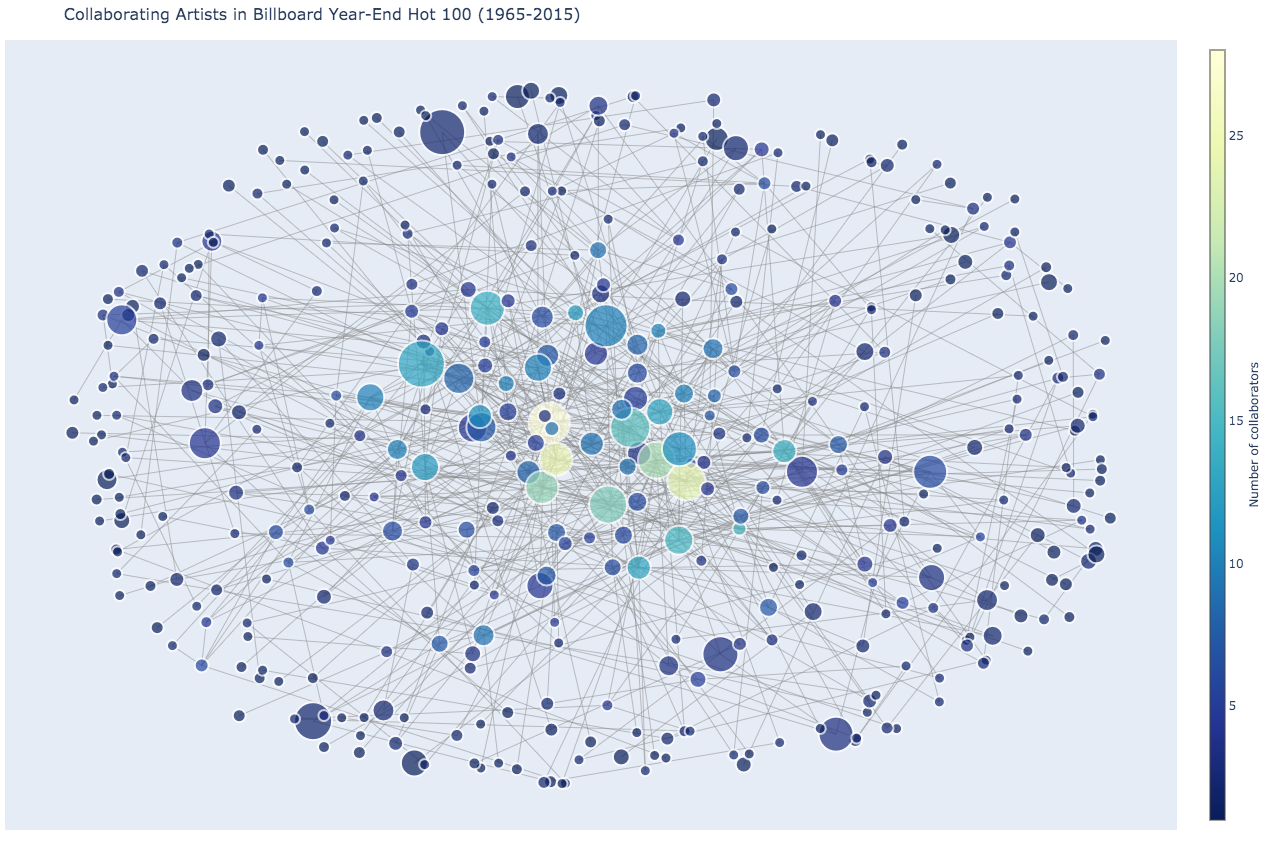

In [29]:
fig.update_layout(height=850)
fig.show()